In [1]:
# workaround via specifying an invalid value first
# %config Application.log_level='WORKAROUND'
# => fails, necessary on Fedora 27, ipython3 6.2.1
# %config Application.log_level='DEBUG'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from polaris.anomaly import detector

from betsi import models, preprocessors, predictors
import json
from sklearn.model_selection import train_test_split
from polaris.data.readers import read_polaris_data



In [2]:
# Plot configurations
plt.rcParams["figure.figsize"] = (25,8)

# Fetching/Loading Data with Polaris tools

In [3]:
# Collect the file the first time with one of the following commands
#!polaris fetch  -s 2019-09-01 -e 2019-09-20 LightSail-2 ls2-2019-09-01-to-2019-09-20.json
#!polaris fetch --skip_normalizer -s 2021-03-01 -e 2021-05-05 BOBCAT-1 ../data/bobcat1-2021-03-01-to-2021-05-05.json

In [4]:
#M = read_polaris_data("../data/bobcat1-2021-03-01-to-2021-05-05.json")


M = read_polaris_data("/home/deckbsd/data/opssat/44878-266-20210520T190154Z-month.json")


# Data from 2021-04-25T02-13-43 upt o 2021-05-05 collected by Hugh
#M2  = read_polaris_data("/home/deckbsd/data/bobcat1-notebook/bobcat1-normalized_frames-recent.json")


# Using Betsi

## Selecting numerical and variable dataset

### Using polaris metadata

In [5]:
type(M[0])

polaris.dataset.metadata.PolarisMetadata

In [6]:
type(M[1])

pandas.core.frame.DataFrame

In [7]:

# Selection per polaris metadata information
column_selection = [c for c in M[0]["analysis"]["column_tags"] if M[0]["analysis"]["column_tags"][c] == "variable" ]
#column_selection2 = [c for c in M2[0]["analysis"]["column_tags"] if M2[0]["analysis"]["column_tags"][c] == "variable" ]

In [8]:
# using the greatest number of 


print("if M has more variables, then these would be missing")
M2not_inM = [c for c in column_selection2 if c not in column_selection]
print(M2not_inM)

print("if M2 has more variables, then this would be missing")
Mnot_inM2 = [c for c in column_selection if c not in column_selection2]
print(Mnot_inM2)

print("----")

all_selection = column_selection2
if len(column_selection) > len(column_selection2):
    all_selection = column_selection
    print("M has more variable columns that M2\n")
    all_selection.extend(M2not_inM)
else: 
    print("M2 has more variable columns that M\n")
    all_selection.extend(Mnot_inM2)

print("Missing variables where added and kept")

if M has more variables, then these would be missing
['sdr_i', 'bootcount_p31', 'bootcause_p31', 'bootcause_a3200', 'resetcause_a3200', 'bootcause_ax100']
if M2 has more variables, then this would be missing
['data', 'tot_rx_count', 'tot_rx_bytes']
----
M2 has more variable columns that M

Missing variables where added and kept


### Concatenating data and removing all remaining non numerical columns

In [9]:
data = pd.concat([M[1][all_selection], M2[1][all_selection]])

In [8]:
data = M[1]

In [9]:
# Overal check of all present variables types
all_types = [data[col].dtype for col in data.columns]
print("{} columns in M with types from (dtype('O') is Object):".format(len(all_types)))
print(np.unique(np.sort(all_types)))


75 columns in M with types from (dtype('O') is Object):
[dtype('int64') dtype('float64') dtype('O')]


In [10]:
data.shape

(3495, 75)

In [11]:
all_numerical_cols = [col for col in data.columns 
                      if data[col].dtype  == "float64" or data[col].dtype == "int64"]
print(all_numerical_cols)

['src_ssid', 'dest_ssid', 'ctl', 'pid', 'priority', 'source', 'destination', 'destination_port', 'source_port', 'reserved', 'csp_hmac', 'csp_xtea', 'csp_rdp', 'csp_crc', 'board_temperature', 'pa_temperature', 'last_received_rssi', 'last_received_rf_error', 'number_of_tx_packets_since_reboot', 'number_of_rx_packets_since_reboot', 'number_of_tx_bytes_since_reboot', 'number_of_rx_bytes_since_reboot', 'active_system_configuration', 'reboot_number', 'reboot_cause', 'last_valid_packet_timestamp', 'background_rssi_level', 'tx_duty_time_since_reboot', 'total_tx_packets', 'total_rx_packets', 'total_tx_bytes', 'total_rx_bytes', 'Fredericksburg K 12-15', 'Planetary K 3-6', 'Planetary K 18-21', 'Planetary K 9-12', 'Planetary K 15-18', 'Fredericksburg K 21-24', 'College K 6-9', 'College K 0-3', 'Fredericksburg K 6-9', 'College K 18-21', 'Fredericksburg K 3-6', 'Fredericksburg K 15-18', 'Fredericksburg K 0-3', 'Fredericksburg A', 'Fredericksburg K 9-12', 'Planetary K 12-15', 'Planetary K 21-24', 'Fr

In [12]:
# Final data column selection

data = data[all_numerical_cols]
print(data.shape)
data.head()

(3495, 73)


src_ssid  dest_ssid  ctl  pid  priority  source  destination  \
0         0          0    3  240       3.0     5.0         10.0   
1         0          0    3  240       3.0     5.0         10.0   
2         0          0    3  240       3.0     5.0         10.0   
3         0          0    3  240       3.0     5.0         10.0   
4         0          0    3  240       3.0     5.0         10.0   

   destination_port  source_port  reserved  ...  Solar Mean Field  X-Ray M  \
0              31.0          0.0       0.0  ...           -0.0001        0   
1              31.0          0.0       0.0  ...           -0.0001        0   
2              31.0          0.0       0.0  ...           -0.0001        0   
3              31.0          0.0       0.0  ...           -0.0001        0   
4              31.0          0.0       0.0  ...           -0.0001        0   

   X-Ray X  Optical 2  X-Ray C  SESC sunspot number    Radio Flux  \
0        0          0        1                   47  7.800000e-21   
1        0          0        1                   47  7.800000e-21   
2        0          0        1                   47  7.800000e-21   
3        0          0        1                   47  7.800000e-21   
4        0          0        1                   47  7.800000e-21   

   Sunspot Area  New Regions          time  
0        0.0032            0  1.621535e+09  
1        0.0032            0  1.621529e+09  
2        0.0032            0  1.621529e+09  
3        0.0032            0  1.621529e+09  
4        0.0032            0  1.621529e+09  

[5 rows x 73 columns]

In [13]:
col_to_remove = ["reserved","src_ssid","dest_ssid","ctl","pid","priority", "source", "destination", "destination_port", "source_port"]

data = data.drop(col_to_remove, axis=1)

# Final data column selection
print(data.shape)
data.head()

(3495, 63)


csp_hmac  csp_xtea  csp_rdp  csp_crc  board_temperature  pa_temperature  \
0       0.0       0.0      0.0      0.0              468.0           464.0   
1       0.0       0.0      0.0      0.0              473.0           469.0   
2       0.0       0.0      0.0      0.0              473.0           469.0   
3       0.0       0.0      0.0      0.0              473.0           469.0   
4       0.0       0.0      0.0      0.0              472.0           468.0   

   last_received_rssi  last_received_rf_error  \
0                 0.0                     0.0   
1                 0.0                     0.0   
2                 0.0                     0.0   
3                 0.0                     0.0   
4                 0.0                     0.0   

   number_of_tx_packets_since_reboot  number_of_rx_packets_since_reboot  ...  \
0                               53.0                                0.0  ...   
1                               71.0                                0.0  ...   
2                               70.0                                0.0  ...   
3                               69.0                                0.0  ...   
4                               68.0                                0.0  ...   

   Solar Mean Field  X-Ray M  X-Ray X  Optical 2  X-Ray C  \
0           -0.0001        0        0          0        1   
1           -0.0001        0        0          0        1   
2           -0.0001        0        0          0        1   
3           -0.0001        0        0          0        1   
4           -0.0001        0        0          0        1   

   SESC sunspot number    Radio Flux  Sunspot Area  New Regions          time  
0                   47  7.800000e-21        0.0032            0  1.621535e+09  
1                   47  7.800000e-21        0.0032            0  1.621529e+09  
2                   47  7.800000e-21        0.0032            0  1.621529e+09  
3                   47  7.800000e-21        0.0032            0  1.621529e+09  
4                   47  7.800000e-21        0.0032            0  1.621529e+09  

[5 rows x 63 columns]

## Data preparation for the betsi auto-encoder based method

### Saving time index

In [14]:
# Keeping time index for later usage
time_index = pd.to_datetime(data.time, unit="s")
print(time_index.describe())

# Because data was built from 2 different dataframes.
time_index.index = range(time_index.shape[0])

count                    3495
unique                   2281
top       2021-05-09 04:50:54
freq                       17
first     2021-04-21 02:54:46
last      2021-05-20 18:20:18
Name: time, dtype: object


### Normalizing data for neural network input

In [15]:
print(data.isna().sum())
print("\n\t Although we have NaN we will imput them on the normalized data")

csp_hmac               1206
csp_xtea               1206
csp_rdp                1206
csp_crc                1206
board_temperature      1206
                       ... 
SESC sunspot number       0
Radio Flux                0
Sunspot Area              0
New Regions               0
time                      0
Length: 63, dtype: int64

	 Although we have NaN we will imput them on the normalized data


In [16]:
# Step 1: Normalize the data
ndata, normalizer = preprocessors.normalize_all_data(data)

ndata = ndata.apply(lambda col: col.fillna(col.mean()),axis=0)

In [17]:
# Step 2: Convert it to columns using fixed stride and window size using Betsi preprocessor
window_size = 10
stride = 5
converted_data = preprocessors.convert_to_column(ndata, window_size=window_size, stride=stride)
print(converted_data.shape)

(698, 630)


In [18]:
# This should be zero here
converted_data.isna().sum().sum()

0

In [19]:
print("The input data {} has {} features all included and {} observations".format(ndata.shape, ndata.shape[1], ndata.shape[0]))
print("Window size is {}\nand stride is {}\n\t ==> thus generating a matrix for neural network input of size {}".format(window_size, stride, converted_data.shape))
print("\n\tFor info {}(observations)/{}(stride) = {}".format(ndata.shape[0], stride, ndata.shape[0]/stride))

The input data (3495, 63) has 63 features all included and 3495 observations
Window size is 10
and stride is 5
	 ==> thus generating a matrix for neural network input of size (698, 630)

	For info 3495(observations)/5(stride) = 699.0


## Neural Network settings

In [20]:
optimizer = "adam"
loss = "mean_squared_error"
metrics = "MSE"
layer_dims = [ converted_data.shape[1], 100, 30]
print(layer_dims)

[630, 100, 30]


In [21]:
# by Default layer activiations are ReLu
ae_model, en_model, de_model = models.custom_autoencoder(layer_dims) #, activations=activations)
# Compile the model for training
ae_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
en_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
de_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Fit and evaluate model

In [22]:
train_data, test_data = train_test_split(
        converted_data,
        test_size=0.10, # usually 33% of data is for testing, 
        shuffle=False, # We disable shuffling since order matters (time)
    )

# You can also play around with the batch_size and epochs and enable
# early_stopping based on your needs
history = ae_model.fit(train_data, train_data, batch_size=32, epochs=1000)

# To test the model to check if it has overfit, you can run:
ae_model.evaluate(test_data, test_data, batch_size=32)

Epoch 1/1000
20/20 [==============================] - 2s 10ms/step - loss: 0.7166 - MSE: 0.7110
Epoch 2/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.5898 - MSE: 0.5838
Epoch 3/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.5315 - MSE: 0.5235
Epoch 4/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.4725 - MSE: 0.4643
Epoch 5/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.4647 - MSE: 0.4561
Epoch 6/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.4544 - MSE: 0.4463
Epoch 7/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.4354 - MSE: 0.4277
Epoch 8/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.4336 - MSE: 0.4262
Epoch 9/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.4281 - MSE: 0.4208
Epoch 10/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.4251 - MSE: 0.4179
Epoch 11/1000
20/20 [========================

20/20 [==============================] - 0s 5ms/step - loss: 0.3596 - MSE: 0.3557
Epoch 86/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3521 - MSE: 0.3482
Epoch 87/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3615 - MSE: 0.3575
Epoch 88/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3445 - MSE: 0.3407
Epoch 89/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3539 - MSE: 0.3501
Epoch 90/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3463 - MSE: 0.3426
Epoch 91/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3473 - MSE: 0.3436
Epoch 92/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3414 - MSE: 0.3376
Epoch 93/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3552 - MSE: 0.3513
Epoch 94/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3509 - MSE: 0.3471
Epoch 95/1000
20/20 [==============================] 

20/20 [==============================] - 0s 8ms/step - loss: 0.3426 - MSE: 0.3396
Epoch 169/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3554 - MSE: 0.3524
Epoch 170/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3522 - MSE: 0.3492
Epoch 171/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3549 - MSE: 0.3518
Epoch 172/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3463 - MSE: 0.3434
Epoch 173/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3480 - MSE: 0.3450
Epoch 174/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3435 - MSE: 0.3407
Epoch 175/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3462 - MSE: 0.3433
Epoch 176/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3433 - MSE: 0.3405
Epoch 177/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3497 - MSE: 0.3467
Epoch 178/1000
20/20 [===================

20/20 [==============================] - 0s 6ms/step - loss: 0.3509 - MSE: 0.3483
Epoch 253/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3371 - MSE: 0.3346
Epoch 254/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3493 - MSE: 0.3469
Epoch 255/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3455 - MSE: 0.3432
Epoch 256/1000
20/20 [==============================] - 0s 16ms/step - loss: 0.3439 - MSE: 0.3415
Epoch 257/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3412 - MSE: 0.3388
Epoch 258/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3598 - MSE: 0.3573
Epoch 259/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3469 - MSE: 0.3444
Epoch 260/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3420 - MSE: 0.3396
Epoch 261/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3457 - MSE: 0.3434
Epoch 262/1000
20/20 [=====================

20/20 [==============================] - 0s 8ms/step - loss: 0.3330 - MSE: 0.3309
Epoch 337/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3351 - MSE: 0.3330
Epoch 338/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3510 - MSE: 0.3488
Epoch 339/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3377 - MSE: 0.3355
Epoch 340/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3473 - MSE: 0.3452
Epoch 341/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3449 - MSE: 0.3428
Epoch 342/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3382 - MSE: 0.3361
Epoch 343/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3423 - MSE: 0.3402
Epoch 344/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3450 - MSE: 0.3429
Epoch 345/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3514 - MSE: 0.3493
Epoch 346/1000
20/20 [======================

20/20 [==============================] - 0s 7ms/step - loss: 0.3472 - MSE: 0.3452
Epoch 420/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3403 - MSE: 0.3384
Epoch 421/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3434 - MSE: 0.3414
Epoch 422/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3473 - MSE: 0.3452
Epoch 423/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3416 - MSE: 0.3395
Epoch 424/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3474 - MSE: 0.3454
Epoch 425/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3462 - MSE: 0.3442
Epoch 426/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3400 - MSE: 0.3380
Epoch 427/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3472 - MSE: 0.3453
Epoch 428/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3418 - MSE: 0.3399
Epoch 429/1000
20/20 [===================

20/20 [==============================] - 0s 8ms/step - loss: 0.3310 - MSE: 0.3292
Epoch 504/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.3352 - MSE: 0.3333
Epoch 505/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.3365 - MSE: 0.3346
Epoch 506/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3317 - MSE: 0.3298
Epoch 507/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3284 - MSE: 0.3266
Epoch 508/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3376 - MSE: 0.3358
Epoch 509/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3331 - MSE: 0.3313
Epoch 510/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3342 - MSE: 0.3324: 0s - loss: 0.3303 - MSE: 0.
Epoch 511/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.3307 - MSE: 0.3289
Epoch 512/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3349 - MSE: 0.3330
Epoch 513/100

20/20 [==============================] - 0s 8ms/step - loss: 0.3407 - MSE: 0.3389
Epoch 587/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3378 - MSE: 0.3361
Epoch 588/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3415 - MSE: 0.3399
Epoch 589/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3312 - MSE: 0.3296
Epoch 590/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3390 - MSE: 0.3373
Epoch 591/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3296 - MSE: 0.3279
Epoch 592/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3307 - MSE: 0.3290
Epoch 593/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.3408 - MSE: 0.3391
Epoch 594/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3282 - MSE: 0.3265
Epoch 595/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.3382 - MSE: 0.3365
Epoch 596/1000
20/20 [==================

20/20 [==============================] - 0s 11ms/step - loss: 0.3390 - MSE: 0.3374
Epoch 670/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.3256 - MSE: 0.3240
Epoch 671/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.3394 - MSE: 0.3378
Epoch 672/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3367 - MSE: 0.3351
Epoch 673/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3332 - MSE: 0.3317
Epoch 674/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.3326 - MSE: 0.3310
Epoch 675/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.3365 - MSE: 0.3349
Epoch 676/1000
20/20 [==============================] - 0s 18ms/step - loss: 0.3272 - MSE: 0.3256
Epoch 677/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3298 - MSE: 0.3282
Epoch 678/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3284 - MSE: 0.3269
Epoch 679/1000
20/20 [===============

20/20 [==============================] - 0s 8ms/step - loss: 0.3336 - MSE: 0.3322
Epoch 752/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3368 - MSE: 0.3351
Epoch 753/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.3433 - MSE: 0.3416: 0s - loss: 0.3544 - MSE: 0.3
Epoch 754/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.3371 - MSE: 0.3356
Epoch 755/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.3389 - MSE: 0.3373
Epoch 756/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3259 - MSE: 0.3244
Epoch 757/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.3340 - MSE: 0.3325
Epoch 758/1000
20/20 [==============================] - 0s 15ms/step - loss: 0.3419 - MSE: 0.3404
Epoch 759/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.3325 - MSE: 0.3311
Epoch 760/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.3341 - MSE: 0.3325
Epoch 

20/20 [==============================] - 0s 5ms/step - loss: 0.3395 - MSE: 0.3381
Epoch 835/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.3363 - MSE: 0.3349
Epoch 836/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3439 - MSE: 0.3424
Epoch 837/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.3275 - MSE: 0.3261
Epoch 838/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3265 - MSE: 0.3251
Epoch 839/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3316 - MSE: 0.3302
Epoch 840/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3249 - MSE: 0.3235
Epoch 841/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.3353 - MSE: 0.3339
Epoch 842/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3420 - MSE: 0.3405
Epoch 843/1000
20/20 [==============================] - 0s 7ms/step - loss: 0.3352 - MSE: 0.3338
Epoch 844/1000
20/20 [=======================

20/20 [==============================] - 0s 10ms/step - loss: 0.3307 - MSE: 0.3292
Epoch 918/1000
20/20 [==============================] - 0s 13ms/step - loss: 0.3282 - MSE: 0.3268
Epoch 919/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3203 - MSE: 0.3188
Epoch 920/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3293 - MSE: 0.3279
Epoch 921/1000
20/20 [==============================] - 0s 14ms/step - loss: 0.3315 - MSE: 0.3301
Epoch 922/1000
20/20 [==============================] - 0s 17ms/step - loss: 0.3434 - MSE: 0.3419
Epoch 923/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3282 - MSE: 0.3268A: 0s - loss: 0.3280 - MSE: 0.3
Epoch 924/1000
20/20 [==============================] - 0s 11ms/step - loss: 0.3322 - MSE: 0.3308
Epoch 925/1000
20/20 [==============================] - 0s 12ms/step - loss: 0.3334 - MSE: 0.3320
Epoch 926/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.3315 - MSE: 0.3301
Epoch 9

20/20 [==============================] - 0s 8ms/step - loss: 0.3274 - MSE: 0.3259
Epoch 1000/1000
3/3 [==============================] - 0s 2ms/step - loss: 0.7492 - MSE: 0.7471


[0.7492175698280334, 0.747107982635498]

In [23]:
train_data.shape

(628, 630)

## Running betsi analysis

### Predict and calculate feature-kernel distances 

In [24]:
# Step 1: Predict the "bottleneck" layer representation for the input data
data_rep = en_model.predict(converted_data)

# Step 2: Measure the distance between consecutive timestamps. This will be
# the metric to detect anomalies. Distance here refers to the L2 norm.
distance_list = []
for row_no in range(data_rep.shape[0] - 1):
    distance_list.append(
        predictors.distance_measure(data_rep[row_no], data_rep[row_no + 1]))

(698, 30)


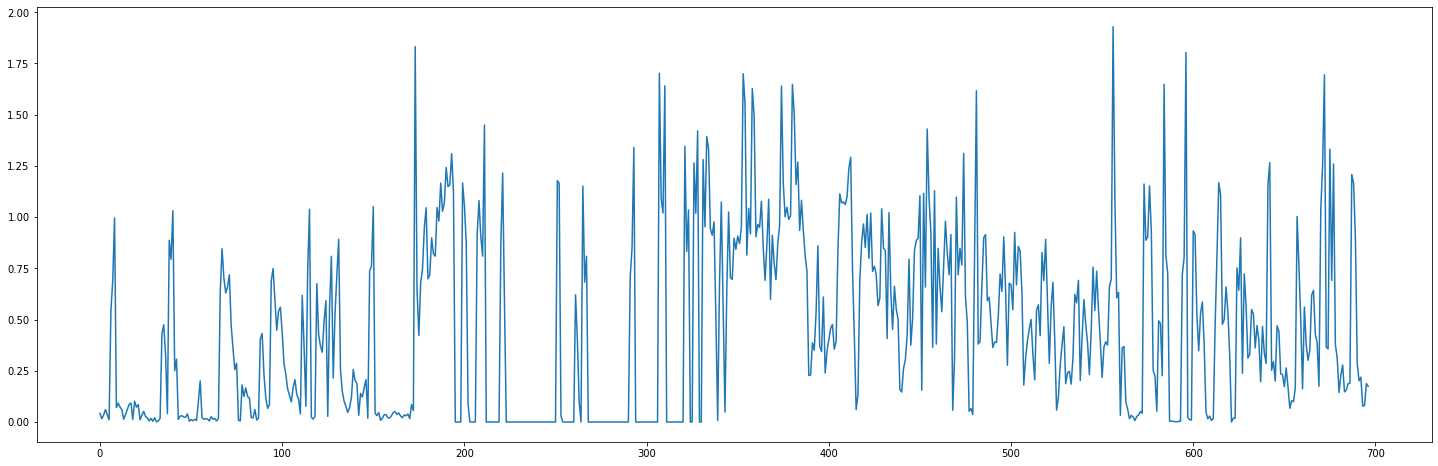

In [25]:
print(data_rep.shape)

plt.plot(distance_list)

In [26]:
# Step 3: Detect the events. We have a noise_margin_per variable to say
# how much (in percentage) should the value be above the average to be
# considered the event. Try playing around with this to find the best value!
noise_margin_per = 50 # 2.5 x the average ie 150% more than average
events = predictors.get_events(distance_list, threshold=noise_margin_per)

In [27]:
print("{} events detected with {}% average deviation".format(len(events), noise_margin_per))
print(events)

53 events detected with 50% average deviation
[71, 99, 124, 131, 179, 182, 185, 190, 193, 196, 204, 211, 256, 310, 328, 337, 345, 348, 353, 356, 361, 367, 374, 377, 380, 383, 391, 412, 419, 429, 433, 444, 450, 458, 464, 467, 478, 486, 511, 523, 552, 559, 576, 581, 588, 605, 618, 642, 661, 672, 675, 682, 692]


### Plot events on the data

In [28]:
#df_test = pd.read_pickle("/tmp/test_data.pkl")

# df_test = pd.read_pickle("/tmp/test_data.pkl")
# events = json.load(open("/tmp/anomaly_metrics.json"))["events"]

In [29]:
# events by order of breakage (difference with previous behavior) in DESC order (biggest first)
sorted_dist = np.argsort(distance_list)[::-1]
events_sorted = [evt for evt in sorted_dist if evt in events]

In [30]:
events_sorted

[353,
 672,
 380,
 310,
 374,
 211,
 328,
 675,
 193,
 412,
 383,
 642,
 190,
 576,
 458,
 450,
 367,
 377,
 185,
 179,
 356,
 429,
 345,
 433,
 464,
 337,
 419,
 361,
 467,
 486,
 182,
 348,
 131,
 444,
 71,
 523,
 618,
 559,
 124,
 605,
 661,
 99,
 511,
 581,
 552,
 391,
 682,
 692,
 478,
 588,
 256,
 204,
 196]

In [31]:
print(distance_list[604])
print(distance_list[360])

0.5313255604742742
0.9044401333153923


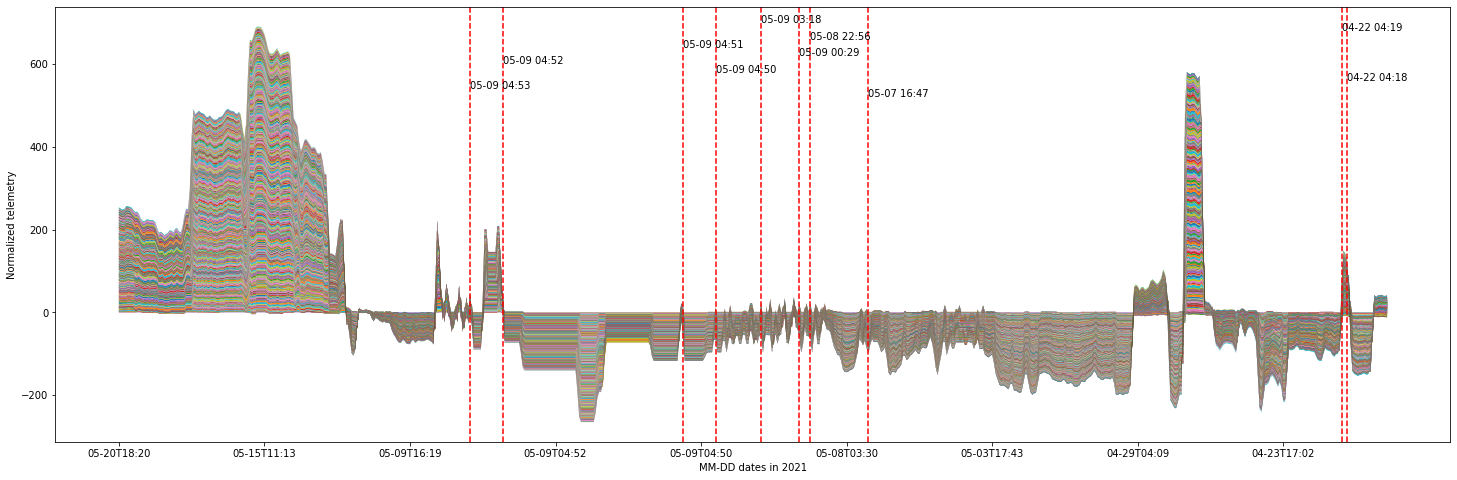

<Figure size 1800x576 with 0 Axes>

In [63]:
plt.close()

ndf = converted_data.to_numpy()

# Time index with one point every stride
ndf_time = (time_index.iloc[::stride]).iloc[:-1]

# To remove columns of data which are constant
#ndf[:, ~np.all(ndf[1:] == ndf[:-1], axis=0)]

# tot_cols = ndf.shape[1] # Not used
tot_rows = ndf.shape[0]

# Creating the stack plot
plt.stackplot(range(ndf.shape[0]), ndf.T)
#plt.stackplot(ndf_time.to_numpy().T, ndf.T)



# Plotting the events on top of the stackplots as dotted lines
#for xc in events:
#    if xc > tot_rows:
#        # Just a fail-safe, made some mistakes before
#        break
#    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
#    plt.axvline(xc, color="k", linestyle="--")

# Plotting in red the 3 biggest changes
y = 700
for xc in events_sorted[:10]:
    if xc > tot_rows:
        # Just a fail-safe, made some mistakes before
        break
    #plt.axvline(ndf_time.iloc[xc], color="k", linestyle="--")
    plt.axvline(xc, color="r", linestyle="--")
    plt.annotate(str(ndf_time.iloc[xc])[5:16], (xc,y))
    y -= 20


At = list(range(ndf.shape[0])[::80])
At_time_str = [str(d)[5:16] for d in ndf_time.to_numpy()[At]]

#big_event_idx =  378
#At.append(big_event_idx)
#At_time_str.append(str(ndf_time.iloc[big_event_idx])[5:16] )
plt.xticks(At, At_time_str)
#plt.axvline(big_event_idx, color="c", linestyle="--")

plt.xlabel("MM-DD dates in 2021")
plt.ylabel("Normalized telemetry")
plt.show()
plt.savefig("ttttt.png")

In [39]:
time_index

0      2021-05-20 18:20:18
1      2021-05-20 16:49:28
2      2021-05-20 16:49:18
3      2021-05-20 16:49:08
4      2021-05-20 16:48:58
               ...        
3490   2021-04-21 02:55:26
3491   2021-04-21 02:55:16
3492   2021-04-21 02:55:06
3493   2021-04-21 02:54:56
3494   2021-04-21 02:54:46
Name: time, Length: 3495, dtype: datetime64[ns]

In [45]:
ndf_time



0      2021-05-20 18:20:18
5      2021-05-20 16:48:48
10     2021-05-20 16:47:38
15     2021-05-20 16:47:16
20     2021-05-20 16:46:48
               ...        
3465   2021-04-21 02:58:06
3470   2021-04-21 02:57:16
3475   2021-04-21 02:56:56
3480   2021-04-21 02:56:26
3485   2021-04-21 02:56:06
Name: time, Length: 698, dtype: datetime64[ns]

In [57]:
ndf.shape

(698, 630)

In [37]:
events_sorted[:10]

[353, 672, 380, 310, 374, 211, 328, 675, 193, 412]

In [33]:
ndf.shape[0]

698

In [34]:
str(ndf_time.iloc[378])

'2021-05-08 22:57:42'

In [35]:
378 in events

False

### Brownbag analysis

In [36]:
ndf_time.iloc[378]

Timestamp('2021-05-08 22:57:42')

In [73]:
ndf_time.iloc[360]

Timestamp('2021-05-09 03:17:30')

In [74]:
# Trying to see how much apart the betsi breakpoint (first datetime) is from information from operators (second datetime)
time_index[(time_index > '2021-04-24 15:38:14') & (time_index <= '2021-04-25 05:20:43')]

3136   2021-04-24 16:48:28
3137   2021-04-24 16:48:18
3138   2021-04-24 16:48:18
3139   2021-04-24 16:48:08
3140   2021-04-24 16:47:58
3141   2021-04-24 16:47:58
3142   2021-04-24 16:47:48
3143   2021-04-24 16:47:48
3144   2021-04-24 16:47:38
3145   2021-04-24 16:47:38
3146   2021-04-24 16:47:28
3147   2021-04-24 16:47:18
3148   2021-04-24 16:47:08
Name: time, dtype: datetime64[ns]

In [75]:
def plot_events_against_real_telemetry(df, events_timestamps=None, savefig="/tmp/hhh.svg"):
    """ Tailored for a dataframe df that has a time column
    """
    plt.close()
    time_idx = pd.to_datetime(df.time, unit="s")
    # In case the time_idx has a wrong numbering
    time_idx.index = range(time_idx.shape[0])
    df.index = time_idx
    
    #plt.stackplot(range(df.shape[0]), df.T)
    normalized_df=(df-df.min())/(df.max()-df.min())
    #print(normalized_df.head())
    plt.plot(normalized_df, "ko", alpha=0.05)
    
    if events_timestamps is not None:
        for evt in events_timestamps:
            plt.axvline(evt, color="r", linestyle="--", linewidth="4", alpha=0.7)
            print(evt)
            
    plt.axvline('2021-04-25 05:20:43', color="c", linestyle="--", linewidth="4", alpha=0.9)
    plt.xlabel("Timestamp")
    plt.ylabel("Normalized telemetry")
    
    plt.savefig(savefig)
    
    plt.show()
    print()

2021-05-16 04:42:53
2021-05-10 17:38:57
2021-05-10 04:40:02
2021-05-09 04:55:36
2021-05-09 04:54:29
2021-05-09 04:54:03
2021-05-09 04:53:53
2021-05-09 04:53:33
2021-05-09 04:53:02
2021-05-09 04:52:58
2021-05-09 04:52:44
2021-05-09 04:52:18
2021-05-09 04:52:05
2021-05-09 04:51:38
2021-05-09 04:50:51
2021-05-09 04:50:44
2021-05-09 04:50:12
2021-05-09 04:49:55
2021-05-09 03:19:43
2021-05-09 03:19:09
2021-05-09 03:18:47
2021-05-09 03:18:08
2021-05-09 03:17:39
2021-05-09 03:17:29
2021-05-09 01:45:10
2021-05-09 01:44:50
2021-05-08 22:58:54
2021-05-08 22:56:22
2021-05-08 22:55:22
2021-05-08 22:54:59
2021-05-08 16:34:13
2021-05-07 16:48:24
2021-05-07 16:47:41
2021-05-07 16:46:01
2021-05-07 16:43:58
2021-05-06 17:02:34
2021-05-05 17:16:37
2021-05-04 17:32:43
2021-05-04 02:56:41
2021-05-04 02:56:16
2021-05-04 02:55:23
2021-05-04 02:53:44
2021-05-04 01:23:04
2021-05-03 17:43:07
2021-05-03 16:10:38
2021-05-01 16:44:00
2021-05-01 03:38:23
2021-04-30 18:29:00
2021-04-30 16:55:59
2021-04-29 17:15:23


ConversionError: Failed to convert value(s) to axis units: '2021-04-25 05:20:43'

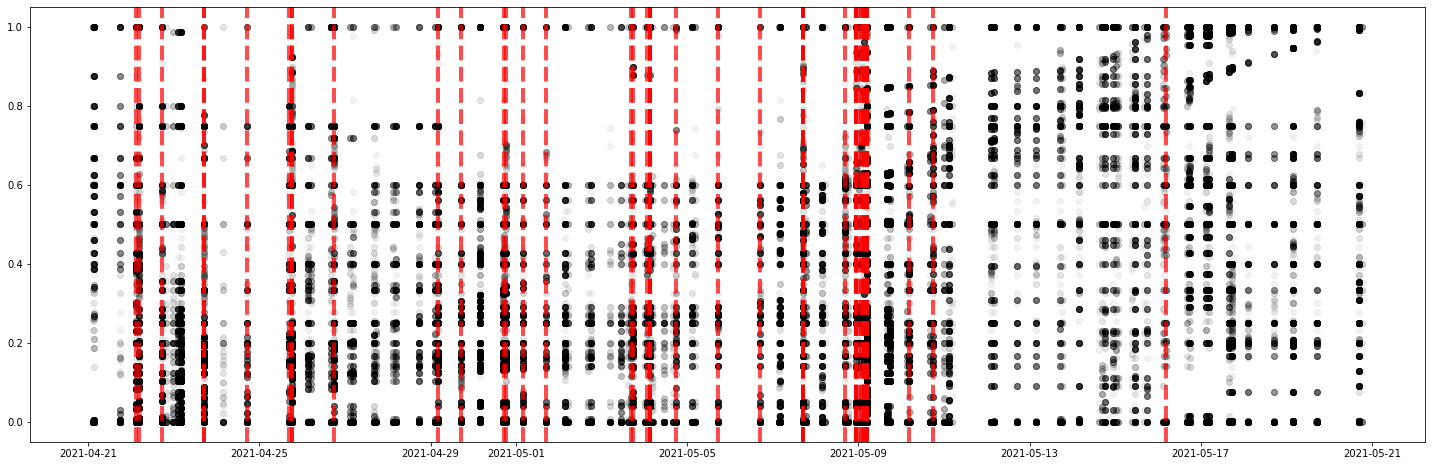

In [76]:
plot_events_against_real_telemetry(data, ndf_time.iloc[events])

In [ ]:
# The window time of window_size
time_index[window_size] - time_index[0] 

In [ ]:
def extract_datasets_around_event(df, timeref, events_list, event_index=10, base_name="../data/bobcat-1-behavior-data"):
    D1 = df[(df.index > timeref.iloc[events_list[event_index-1]]) & (df.index <= timeref.iloc[events_list[event_index]])]
    D2 = df[(df.index > timeref.iloc[events_list[event_index]]) & (df.index <= timeref.iloc[events_list[event_index+1]])]
    print("Two datasets around {}".format(timeref.iloc[events_list[event_index]]))
    D1.to_csv(base_name+"-B1.csv")
    D2.to_csv(base_name+"-B2.csv")
    

In [ ]:
ndf_time.iloc[events[9]]

In [ ]:
extract_datasets_around_event(data, ndf_time, events, 10)

In [ ]:
extract_datasets_around_event(data, ndf_time, events, 9, base_name="../data/bobcat-1-behavior-around-2021-04-12")

## Comparing graphs of two consecutive behavior periods

In [ ]:
graph_before = "../data/bobcat-1-behavior-around-2021-04-12-BEFORE.json"
graph_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER.json"
graph_after_after  = "../data/bobcat-1-behavior-around-2021-04-12-AFTER-AFTER.json"

In [ ]:
def compare_two_graphs(gbefore, gafter):
    with open(gbefore, "r") as fff:
        json_before = json.load(fff)
    
    with open(gafter, "r") as fff:
        json_after = json.load(fff)
        
    for node in json_after["graph"]["nodes"]:
        if node not in json_before["graph"]["nodes"]:
            print("missing node from before: "+node)
                 
    for node in json_before["graph"]["nodes"]:
        if node not in json_after["graph"]["nodes"]:
            print("missing node from after: "+node)
            
    #uniqsrc = np.uniq([elt["source"] for elt in json_after["graph"]["links"]])
    
    def build_link_db(graph):
        db = {}
        for elt in graph["graph"]["links"]:
            if elt["source"] not in db:
                db[elt["source"]] = {}
            db[elt["source"]][elt["target"]] = elt["value"]
        return db
    
    after_db = build_link_db(json_after)
    before_db = build_link_db(json_before)
    for src in after_db:
        if src in before_db:
            for target in after_db[src]:
                if target in before_db[src]:
                    A = after_db[src][target]
                    B = before_db[src][target]
                    adiff = np.abs(A-B)
                    if adiff > 0.0:
                        if A > B:
                            A = B
                        if A/adiff > 0.2:
                            print("Consequent change on pair {} --> {} = from {} to {} ".format(
                                  src, target, before_db[src][target], after_db[src][target]))
                else:
                    print("New pair from already existing source {} --> {} = {} ".format(src, target, after_db[src][target]))
        else:
            print("No links were present before from that paramater:   "+src)
            for target in after_db[src]:
                print("\t--> "+target)

In [ ]:
compare_two_graphs(graph_before, graph_after)

In [ ]:
compare_two_graphs(graph_after, graph_after_after)

In [ ]:
compare_two_graphs(graph_before, graph_after_after)